In [401]:
%matplotlib inline
from sensible_raw.loaders import loader
import numpy as np
from sklearn.preprocessing import scale
matplotlib.use('Agg')

In [402]:
from sensible_raw.loaders import loader
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import subprocess
import os
import json
import datetime
from datetime import datetime as dt
import numpy as np

In [403]:
dt.strptime("1", '%m').strftime("%B")

'January'

In [404]:
class Sms_extractor:
    """Extract features from SMS data for a single user
    
    Run the main function with a user ID and a list of time ranges. Every 
    feature extractor within class computes a float value for each time range.
    
    Parameters
    ----------
    time_constraint : list object
        Every item is a dict of form {'hours': <list of hours>, 'days': <list of days>, 
        'spans': <list of timespan-tuples>}
        
    Output
    ------
    datapoint : dict

        Example
        -------
            {'fractions_of_conversations_started': 0.34782608695652173,
             'incoming_messages': 3.6888794541139363,
             'outgoing_messages': 3.4339872044851463,
             'overall_received_responsiveness': -9.0581865605306326,
             'overall_responsiveness': -9.0610147611536238,
             'selectivity_in_responsiveness': -5.4102083517105317}
    """
    
    def __init__(self, time_constraint, suppress=[], auxlabel=""):
        
        self.suppress = suppress
        self.auxlabel = auxlabel

        months = [dt.strptime(str(m+1), '%m').strftime("%B").lower() for m 
                  in time_constraint['months']]
        years = time_constraint['years']

        df_sms = pd.DataFrame()

        for y in years:
            for m in months:
                columns_sms, data_sms = loader.load_data("sms", "%s_%d" % (m, y))
                dict_tmp = {}
                for column, array in zip(columns_sms, data_sms):
                    dict_tmp[column] = array
                df_sms = pd.concat([df_sms, pd.DataFrame(dict_tmp)], ignore_index=True)
        
        # Filter out non-delivered messages
        self.df_sms = df_sms[df_sms['status'] <= 0]
        
        # Apply hours and days constraints
        hod = lambda x: np.floor(x%86400/3600)
        dow = lambda x: np.floor((x%(86400*7)/86400+3)%7) #add 3 days cause 0th second is thursday (index 3)
        
        df_sms = df_sms[(hod(df_sms['timestamp']/1000).isin(time_constraint['hours'])) & 
                        (dow(df_sms['timestamp']/1000).isin(time_constraint['days']))]
        
        # Sort dataframe
        df_sms = df_sms.sort(['timestamp'], ascending=[1])
        
        print "Number of datapoints in range:", len(df_sms)
        
        
    # -------------------- #
    # Supporting functions #
    # -------------------- #
    
    def __partition_dyad_messages_to_conversations(self, messages):
        conversations = []

        timestamps = sorted(messages['timestamp']/1000)

        conversation_breaks = []
        for i, _ in enumerate(timestamps):
            if i == 0:
                continue
            delta_t = timestamps[i] - timestamps[i-1]

            if delta_t > self.expiration_time * 3600:
                start_break = int(timestamps[i-1])
                end_break = int(timestamps[i])
                conversation_breaks.append([start_break, end_break])

        conversations = []

        if len(conversation_breaks) == 0:
            conversations.append(messages)
            return conversations

        for i, _ in enumerate(conversation_breaks):
            if i == 0:
                conv_end = conversation_breaks[i][0]
                conversation = messages[
                    messages['timestamp']/1000 <= conv_end]
                conversations.append(conversation)
                continue
            if i == len(conversation_breaks)-1:
                conv_start = conversation_breaks[i][1]
                conversation = messages[
                    messages['timestamp']/1000 >= conv_start]
                conversations.append(conversation)
                continue

            conv_start = conversation_breaks[i-1][1]
            conv_end = conversation_breaks[i][0]
            conversation = messages[
                messages['timestamp']/1000 >= conv_start][
                messages['timestamp']/1000 <= conv_end]

            conversations.append(conversation)

        return conversations
    
    
    def __compute_user_conversations(self, expiration_time=6):
        
        self.expiration_time = expiration_time
    
        user_messages = self.df_sms[self.df_sms['user']==self.user]

        # the people that the user texts with
        conversers = set(user_messages['address'])

        user_conversations = {}

        for c in conversers:
            c_messages = user_messages[user_messages['address'] == c]

            c_conversations = self.__partition_dyad_messages_to_conversations(c_messages)

            user_conversations[c] = c_conversations

        return user_conversations
    
    
    def __compute_conversation_response_times(self, conversation):
        conversation = conversation.sort(['timestamp'],ascending=[1])
        
        response_times = defaultdict(list)

        sender_prev = {}
        sender = {}

        for i, message in enumerate(conversation.iterrows()):

            if i == 0:
                initiator = message[1]['type']
                sender_prev = {'actor': message[1]['type'],
                            'timestamp': message[1]['timestamp']}
                continue

            sender = {'actor': message[1]['type'],
                      'timestamp': message[1]['timestamp']}

            if sender['actor'] == sender_prev['actor']:
                continue

            response_time = (sender['timestamp'] - sender_prev['timestamp'])/1000

            response_times[sender['actor']].append(response_time)

            sender_prev = {'actor': message[1]['type'],
                           'timestamp': message[1]['timestamp']}
        
        response_time_user = np.mean(response_times[2])
        response_time_converser = np.mean(response_times[1])
        
        # Add expiration_time in seconds to response time for he who doesn't respond
        if np.isnan(response_time_user) and initiator == 1:
            response_time_user = self.expiration_time * 3600
        if np.isnan(response_time_converser) and initiator == 2:
            response_time_converser = self.expiration_time * 3600
            
            
        #print self.expiration_time

        return response_time_user, response_time_converser
    
    
    def __compute_responsiveness_from_responsetimes(self,responsetimes):
        if len(responsetimes)==0: return 0
        return 1.0/np.mean(responsetimes)
        
    
    
    # ------------------- #
    # Computate functions #
    # ------------------- #
    
    def _compute_outgoing_messages(self):
        outgoing_messages = self.df_sms[self.df_sms['user']==self.user][self.df_sms['type']==2]
        return {'%soutgoing_messages' % self.auxlabel: len(outgoing_messages)+1}

    def _compute_incoming_messages(self):
        incoming_messages = self.df_sms[self.df_sms['user']==self.user][self.df_sms['type']==1]
        return {'%sincoming_messages' % self.auxlabel: len(incoming_messages)+1}
    
    def _compute_features_4_to_7(self):
        user_conversations = self.__compute_user_conversations()

        converser_response_times = {}
        conversations_started = 0
        conversations_count = 0

        i = 0
        for converser, conversations in user_conversations.items():

            # compute response times
            response_times = [self.__compute_conversation_response_times(c) for c in conversations] #[(907.0, 36.0), (nan, nan), (239.0, 205.0), (140.0, 50.0)]

            average_outgoing = np.mean([r[0] for r in response_times])
            average_incoming = np.mean([r[1] for r in response_times])

            converser_response_times[converser] = {'average_outgoing': average_outgoing, 'average_incoming': average_incoming}

            conversations_started += len([c for c in conversations if list(c['type'])[0] == 2])
            conversations_count += len(conversations)

            #i += 1
            #if i > 5:
            #    return converser_response_times

        # compute feature 4
        responsetimes_list = [v['average_outgoing'] for k,v in converser_response_times.items()
                               if not np.isnan(v['average_outgoing'])]
        
        overall_responsiveness = self.__compute_responsiveness_from_responsetimes(
            responsetimes_list)

        # compute feature 5
        received_responsetimes_list = [v['average_incoming'] for k,v in converser_response_times.items() 
                                        if not np.isnan(v['average_incoming'])]
        
        overall_received_responsiveness = self.__compute_responsiveness_from_responsetimes(
            received_responsetimes_list)
        
        # compute feature 6
        selectivity_in_responsiveness = np.std(1.0/np.array(responsetimes_list))+0.0001

        # compute feature 7
        fractions_of_conversations_started = conversations_started * 1.0/conversations_count

        return {'%soverall_responsiveness' % self.auxlabel: overall_responsiveness, 
                '%soverall_received_responsiveness' % self.auxlabel: overall_received_responsiveness, 
                '%sselectivity_in_responsiveness' % self.auxlabel: selectivity_in_responsiveness, 
                '%sfractions_of_conversations_started' % self.auxlabel: fractions_of_conversations_started}
    
    
    def __transform_datapoint(self,datapoint):
        instructions = {'%sfractions_of_conversations_started' % self.auxlabel: (lambda x: x), 
                        '%sincoming_messages' % self.auxlabel: (lambda x: np.log(x)), 
                        '%soutgoing_messages' % self.auxlabel: (lambda x: np.log(x)), 
                        '%soverall_received_responsiveness' % self.auxlabel: (lambda x: np.log(x+0.00001)),
                        '%soverall_responsiveness' % self.auxlabel: (lambda x: np.log(x)),
                        '%sselectivity_in_responsiveness' % self.auxlabel: (lambda x: np.log(x))}
        
        datapoint = dict((k, instructions[k](v)) for k,v in datapoint.items())
        
        return datapoint
                        

    
    def main(self, user, transformed=True):
        
        self.user = user
        
        if len(self.df_sms[self.df_sms['user'] == self.user]) == 0:
            raise Exception('User %s not in dataset' % user)
        
        datapoint_sms = {}
        
        extractors = [self._compute_outgoing_messages(), 
                      self._compute_incoming_messages(), 
                      self._compute_features_4_to_7()]
        
        for i, e in enumerate(extractors):
            if i in self.suppress:
                continue
            datapoint_sms.update(e)
            
        if transformed:
            datapoint_sms = self.__transform_datapoint(datapoint_sms)        
        
        return datapoint_sms

In [406]:
time_constraint = {'hours': range(8,17), 'days': range(0,5), 'months': [0,1], 'years': [2014,2015]}
se = Sms_extractor(time_constraint, suppress=[], auxlabel="tp1_")

Number of datapoints in range: 302999


In [407]:
se.

{'tp1_fractions_of_conversations_started': 0.3350253807106599,
 'tp1_incoming_messages': 5.9889614168898637,
 'tp1_outgoing_messages': 5.8230458954830189,
 'tp1_overall_received_responsiveness': -8.4182935568986945,
 'tp1_overall_responsiveness': -9.0132494497449311,
 'tp1_selectivity_in_responsiveness': -4.5987334816701626}

In [408]:
dataset = {}

for user in range(1000):
    try:
        dataset[user] = se.main(user)
    except Exception:
        pass
    
    if user%10 == 0:
        print user,

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [400]:
features = dataset.items()[0][1].keys()

X = []
for k,v in dataset.items():
    X.append([v[f] for f in features])
    
X = np.array(X)

NameError: name 'dataset' is not defined

In [608]:
X_scaled = scale(X)

In [548]:
np.savetxt("behavior_sms.csv", X_scaled, delimiter=",")

In [399]:
i = 0
plt.hist(X[:,i],20)
plt.label(features[i])
plt.show()

NameError: name 'X' is not defined

In [639]:
print features[0]

overall_responsiveness


In [633]:
for v in filter(lambda x: x>-6, X[:,0]):
    print list(X[:,0]).index(v)

101
577
677


In [642]:
df_sms[df_sms['user']==101].sort(['timestamp'], ascending=([1]))

,address,status,timestamp,type,user
102190,991,-1,1392222209000,1,101
102191,14867,-1,1392238679000,2,101
102192,6140,-1,1392239956000,1,101
102193,14867,-1,1392242021000,1,101
109098,2215,-1,1392311988000,2,101
109099,2215,-1,1392312203000,2,101
121459,589,-1,1392427435000,1,101
121460,589,-1,1392427486000,2,101
121461,589,-1,1392427504000,1,101
136380,2216,-1,1392571630000,1,101


In [657]:
dt.strptime("1", '%m').strftime("%B")

'January'

In [59]:
months = ['january', 'february', 'march', 'april']
years = [2013, 2014]

df_sms = pd.DataFrame()

for y in years:
    for m in months:
        columns_sms, data_sms = loader.load_data("sms", "%s_%d" % (m, y))
        dict_tmp = {}
        for column, array in zip(columns_sms, data_sms):
            dict_tmp[column] = array
        df_sms = pd.concat([df_sms, pd.DataFrame(dict_tmp)])

In [60]:
print len(df_sms)

1104362


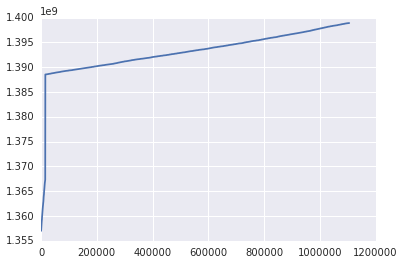

In [62]:
y = sorted(list(df_sms['timestamp']/1000))
x = range(len(y))
plt.plot(x, y)
plt.show()

In [51]:
list(df_sms['timestamp']/1000)

[1325377003.0,
 1325377115.0,
 1325442092.0,
 1325445449.0,
 1325445449.0,
 1325446599.0,
 1325448023.0,
 1325448636.0,
 1325448881.0,
 1325450630.0,
 1325450630.0,
 1325469202.0,
 1325492549.0,
 1325495594.0,
 1325512465.0,
 1325518296.0,
 1325536847.0,
 1325536914.0,
 1325537172.0,
 1325537220.0,
 1325537518.0,
 1325537629.0,
 1325543802.0,
 1325583420.0,
 1325583420.0,
 1325585303.0,
 1325596478.0,
 1325596538.0,
 1325695911.0,
 1325695960.0,
 1325695991.0,
 1325697889.0,
 1325697976.0,
 1325698054.0,
 1325704308.0,
 1325958351.0,
 1325958390.0,
 1326012861.0,
 1326109384.0,
 1326109384.0,
 1326109422.0,
 1326192101.0,
 1326386386.0,
 1326386516.0,
 1326386564.0,
 1326386680.0,
 1326410331.0,
 1326460746.0,
 1326462376.0,
 1326462378.0,
 1326556441.0,
 1326556630.0,
 1326556718.0,
 1326556792.0,
 1326556867.0,
 1326569702.0,
 1326716039.0,
 1326716087.0,
 1326716101.0,
 1326746630.0,
 1326746981.0,
 1326991722.0,
 1326992026.0,
 1326992074.0,
 1326992778.0,
 1327008280.0,
 132706392

In [23]:
pieces = [df[:3], df[3:7], df[7:]]

In [162]:

timestamp = 1418376321
print "second\t", dt.fromtimestamp(timestamp).second
print "minute\t", dt.fromtimestamp(timestamp).minute
print "hour\t", dt.fromtimestamp(timestamp).hour
print "day\t", dt.fromtimestamp(timestamp).day
print "month\t", dt.fromtimestamp(timestamp).month
print "year\t", dt.fromtimestamp(timestamp).year
print "weekday\t", dt.fromtimestamp(timestamp).weekday()
print
print dt.fromtimestamp(timestamp)
print hod(timestamp)
print dow(timestamp)

second	21
minute	25
hour	9
day	12
month	12
year	2014
weekday	4

2014-12-12 09:25:21
9
4


In [182]:
hours = range(8,17)
days = range(0,5)

hod = lambda x: x%86400/3600
dow = lambda x: (x%(86400*7)/86400+3)%7

In [160]:
valid_hour(timestamp+1000000)
valid_days(timestamp)

True

In [161]:
from random import randrange
tmp = []
for i in range(10000):
    tmp.append(dow(randrange(1000000000)))
    
tmp = set(tmp)
print tmp

set([0, 1, 2, 3, 4, 5, 6])


In [183]:
len(df_sms[hod(df_sms['timestamp']).isin(hours)])

23250

In [356]:
months = [dt.strptime(str(m+1), '%m').strftime("%B").lower() for m 
                  in time_constraint['months']]

years = time_constraint['years']

df_sms = pd.DataFrame()

for y in years:
    for m in months:
        columns_sms, data_sms = loader.load_data("sms", "%s_%d" % (m, y))
        dict_tmp = {}
        for column, array in zip(columns_sms, data_sms):
            dict_tmp[column] = array
        df_sms = pd.concat([df_sms, pd.DataFrame(dict_tmp)], ignore_index=True)

# Filter out non-delivered messages
df_sms = df_sms[df_sms['status'] <= 0]

# Apply hours and days constraints
hod = lambda x: np.floor(x%86400/3600)
dow = lambda x: np.floor((x%(86400*7)/86400+3)%7) #add 3 days cause 0th second is thursday (index 3)

df_sms = df_sms[(hod(df_sms['timestamp']/1000).isin(time_constraint['hours'])) & 
                (dow(df_sms['timestamp']/1000).isin(time_constraint['days']))]



In [360]:
df_sms

,address,status,timestamp,type,user
5261,2668,-1,1388563210000,2,99
5164,991,-1,1388563332000,1,544
11167,4694,-1,1388563563000,1,336
7474,4613,-1,1388563566000,1,231
11168,4694,-1,1388563592000,2,336
11169,4694,-1,1388563635000,1,336
18291,21308,-1,1388563696000,2,229
7264,991,-1,1388563856000,1,242
6577,991,-1,1388564105000,1,157
6441,18876,-1,1388564227000,1,83


In [352]:
print len(set(x))

207247


In [337]:
indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
